# Update Version 2.0

In [1]:
import re, math
from collections import defaultdict

def tokenize(_str):
    stopwords = ['the','a','an','and','but','if','or','because','as','what','which','this','that','these','those','then',
              'just','so','than','such','both','through','about','for','is','of','while','during','to','What','Which',
              'is','if','while','this']
    tokens = defaultdict(lambda: 0,)
    for m in re.finditer(r"(\w+)", _str, re.UNICODE):
        m = m.group(1).lower()
        if len(m) < 2: continue
        if m in stopwords: continue
        tokens[m] += 1

    return tokens
#end of tokenize

def kldiv(_s, _t):
    if (len(_s) == 0):
        return 1e33

    if (len(_t) == 0):
        return 1e33

    ssum = 0. + sum(_s.values())
    slen = len(_s)

    tsum = 0. + sum(_t.values())
    tlen = len(_t)

    vocabdiff = set(_s.keys()).difference(set(_t.keys()))
    lenvocabdiff = len(vocabdiff)

    """ epsilon """
    epsilon = min(min(_s.values())/ssum, min(_t.values())/tsum) * 0.001

    """ gamma """
    gamma = 1 - lenvocabdiff * epsilon

    # print "_s: %s" % _s
    # print "_t: %s" % _t

    """ Check if distribution probabilities sum to 1"""
    sc = sum([v/ssum for v in _s.values()])
    st = sum([v/tsum for v in _t.values()])

    if sc < 9e-6:
        print ("Sum P: %e, Sum Q: %e" % (sc, st))
        print ("*** ERROR: sc does not sum up to 1. Bailing out ..")
        sys.exit(2)
    if st < 9e-6:
        print ("Sum P: %e, Sum Q: %e" % (sc, st))
        print ("*** ERROR: st does not sum up to 1. Bailing out ..")
        sys.exit(2)

    div = 0.
    for t, v in _s.items():
        pts = v / ssum

        ptt = epsilon
        if t in _t:
            ptt = gamma * (_t[t] / tsum)

        ckl = (pts - ptt) * math.log(pts / ptt)

        div +=  ckl

    return div
#end of kldiv

In [2]:
import pandas as pd
df = pd.read_csv(r"L:\HP\Data Mining\TASA\Associated Modules\Set-3\tutorial\scrapped.csv")
news = df["text"].dropna()

In [3]:
news = list(news)

In [32]:
len(news)

57

## Printing KL Divergence

In [35]:
def printforallnews():
    counti=counto=1
    for n1 in news:
        for n2 in news:
            if n1 == n2:
                continue
            else:
                print("Document Number "+str(counto)+" To "+str(counti))
                kl1=kldiv(tokenize(n1), tokenize(n2))
                kl2=kldiv(tokenize(n2), tokenize(n1))
                #print ("KL-divergence between d1 and d2:",kl1 )
                #print ("KL-divergence between d2 and d1:",kl2 )
                print ("KL-divergence Average",(kl1+kl2)/2 )
                print ("KL-divergence Normalised",math.atan((kl1+kl2)/2) / 3.1416 + 1 / 2,"\n\n")
            counti += 1
        counti = 0
        counto += 1

## Loading for future Reference

In [4]:
def dictforallnews():
    kldict = dict();relkldict = dict();klist=list()
    counti=counto=1
    for n1 in news:
        for n2 in news:
            if n1 == n2:
                continue
            else:
                #print("Document Number "+str(counto)+" To "+str(counti))
                kl1=kldiv(tokenize(n1), tokenize(n2))
                kl2=kldiv(tokenize(n2), tokenize(n1))
                #print ("KL-divergence between d1 and d2:",kl1 )
                #print ("KL-divergence between d2 and d1:",kl2 )
                klavg = (kl1+kl2)/2
                #print ("KL-divergence Average",klavg )
                klnorm = math.atan(klavg) / 3.1416 + 1 / 2
                #print(counto," ",counti)
                kldict[str(counto) + str(counti)] = klnorm;
                klist.append(klnorm)
                pn1,pn2 = computepolarity(n1,n2)
                rp1,rp2 = relativepolarity(pn1,pn2,klnorm)
                relkldict[str(counto) + str(counti)] = avg(rp1,rp2)
                #print(rp1,rp2)
                
                
            counti += 1
        
        counti = 1
        counto += 1
    return kldict,relkldict,klist

In [126]:
l[:10]

[0.934655641891887,
 0.9315796382178232,
 0.9334916738335419,
 0.9310356260069359,
 0.9322932227519682,
 0.9227580083820589,
 0.9421299176074598,
 0.9449997424833891,
 0.9465572794929179,
 0.9311121430319269]

In [5]:
from textblob import TextBlob

In [6]:
def computepolarity(n1,n2):
    tn1 = TextBlob(n1);tn2 = TextBlob(n2)
    parapoln1 = tn1.sentiment.polarity;parapoln2 = tn2.sentiment.polarity
    return parapoln1,parapoln2
    

In [7]:
def relativepolarity(pn1,pn2,KL):
    rp1 = pn1 * KL
    rp2 = pn2 * KL
    return rp1,rp1
    

In [8]:
def avg(a,b):
    c = (a + b)/2
    return c

In [9]:
k,rk,l = dictforallnews()

In [10]:
lrk = list(rk.values())

## Ratio Old Technique

In [11]:
import pandas as pd
from textblob import TextBlob
df = pd.read_csv(r"L:\HP\Data Mining\TASA\Associated Modules\Set-3\tutorial\scrapped.csv")
news = df["text"].dropna()
ps = 0;tnew = 0.0;ratios = []
ratio = 0.0;
paragraph = []
for new in news:
    senval = []
    senew = TextBlob(new).sentences
    parapol = TextBlob(new).sentiment.polarity
    #print("Paragraph pol",parapol)
    count = 0
    for sen in senew:
        count = count + 1
        senpol = sen.sentiment.polarity
        try:
            ratio = senpol/parapol
            ratios.append(ratio)
        except ZeroDivisionError:
            ratios.append(0)


In [12]:
nratio = list()
for e in ratios:
    nratio.append(math.atan(e) / 3.1416 + 1 / 2) 

In [69]:
nratio[1:3]

[0.6202244999700286, 0.9117162855159027]

In [19]:
lrk = lrk[:1255]

In [20]:
x = nratio
y = lrk

In [13]:
import matplotlib.pyplot as plt

In [137]:
colors = ['blue','red']

In [22]:
color = ['cyan','violet']

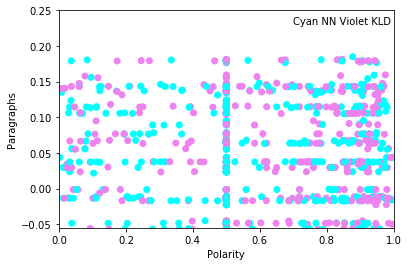

In [25]:
plt.xlabel("Polarity")
plt.ylabel("Paragraphs")
plt.axis([0,1,-0.055,0.25])
plt.scatter(x,y,c=color,label = color)
plt.text(0.7,0.23,r'Cyan NN Violet KLD')
plt.show()

In [86]:
import pickle
npnrk,npnratio = [],[]
fo1 = open('NonPolitocol1.pkl','rb')
fo2 = open('NonPolitocol2.pkl','rb')
npnrk = pickle.load(fo1)
npnratio = pickle.load(fo2)
    

In [142]:
colors = ['Aqua','Purple']

In [141]:
nlrk = lrk[:548]

In [98]:
nnratio = nratio[:548]

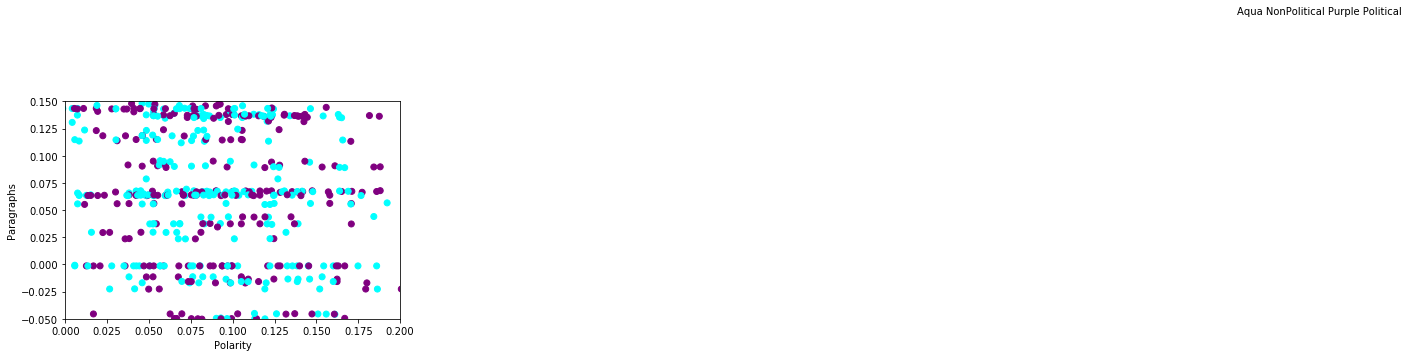

In [144]:
plt.xlabel("Polarity")
plt.ylabel("Paragraphs")
plt.axis([0,0.2,-0.05,0.15])
plt.scatter(npnrk,nlrk,c=colors,label = colors)
plt.text(0.7,0.23,r'Aqua NonPolitical Purple Political')
plt.show()

In [102]:
nppratio = list()
for e in npnratio:
    nppratio.append(math.atan(e) / 3.1416 + 1 / 2) 

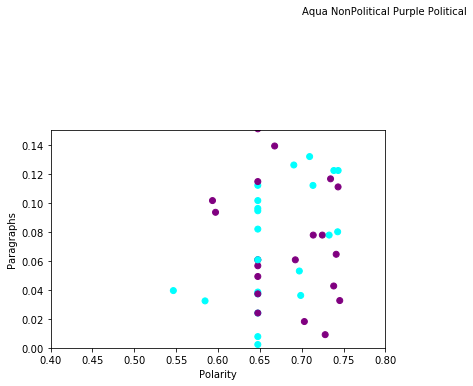

In [106]:
plt.xlabel("Ratio")
plt.ylabel("Paragraphs")
plt.axis([0.4,0.8,0,0.15])
plt.scatter(nppratio,nnratio,c=colors,label = colors)
plt.text(0.7,0.23,r'Aqua NonPolitical Purple Political')
plt.show()

# Nonpolitical and Political

In [151]:
dff = pd.read_csv(r"L:\HP\Data Mining\TASA\Data\Data\Non-Political\scrapped.csv")
nonpol = dff["text"].dropna()
def dictforallnews():
    kldict = dict();relkldict = dict();klist = list()
    counti=counto=1
    for n1 in news:
        for n2 in nonpol:
            if n1 == n2:
                continue
            else:
                #print("Document Number "+str(counto)+" To "+str(counti))
                kl1=kldiv(tokenize(n1), tokenize(n2))
                kl2=kldiv(tokenize(n2), tokenize(n1))
                #print ("KL-divergence between d1 and d2:",kl1 )
                #print ("KL-divergence between d2 and d1:",kl2 )
                klavg = (kl1+kl2)/2
                #print ("KL-divergence Average",klavg )
                klnorm = math.atan(klavg) / 3.1416 + 1 / 2
                #print(counto," ",counti)
                kldict[str(counto) + str(counti)] = klnorm;
                klist.append(klnorm)
                pn1,pn2 = computepolarity(n1,n2)
                rp1,rp2 = relativepolarity(pn1,pn2,klnorm)
                relkldict[str(counto) + str(counti)] = avg(rp1,rp2)
                #print(rp1,rp2)
                
                
            counti += 1
        
        counti = 1
        counto += 1
    return kldict,relkldict,klist

In [152]:
nonpol,relnonpol,l = dictforallnews()

In [147]:
lrelnonpol = list(relnonpol.values())

In [153]:
l[:10]

[0.9507042585931298,
 0.9486565263422888,
 0.9480630921960003,
 0.94804749112186,
 0.9493125005999594,
 0.9465321787816445,
 0.9449747843513651,
 0.947169686755474,
 0.9686092689858841,
 0.9466565770532398]

In [148]:
lrelnonpol[:10]

[0.1488585490297163,
 0.1485379209806607,
 0.14844500276223185,
 0.14844255999074027,
 0.1486406315505515,
 0.14820529672590005,
 0.14796144436796338,
 0.14830511589797313,
 0.15166206425891235,
 0.14822477465086367]

In [149]:
lrk[:10]

[0.1463457026061436,
 0.14586407076365157,
 0.14616345182235244,
 0.14577889089027332,
 0.14597580178557848,
 0.1444828052380586,
 0.1475160032837851,
 0.14796535224077031,
 0.14820922692335736,
 0.1457908717068241]

In [111]:
len(lrk)

1255

In [112]:
nlrel = lrelnonpol[:1255]

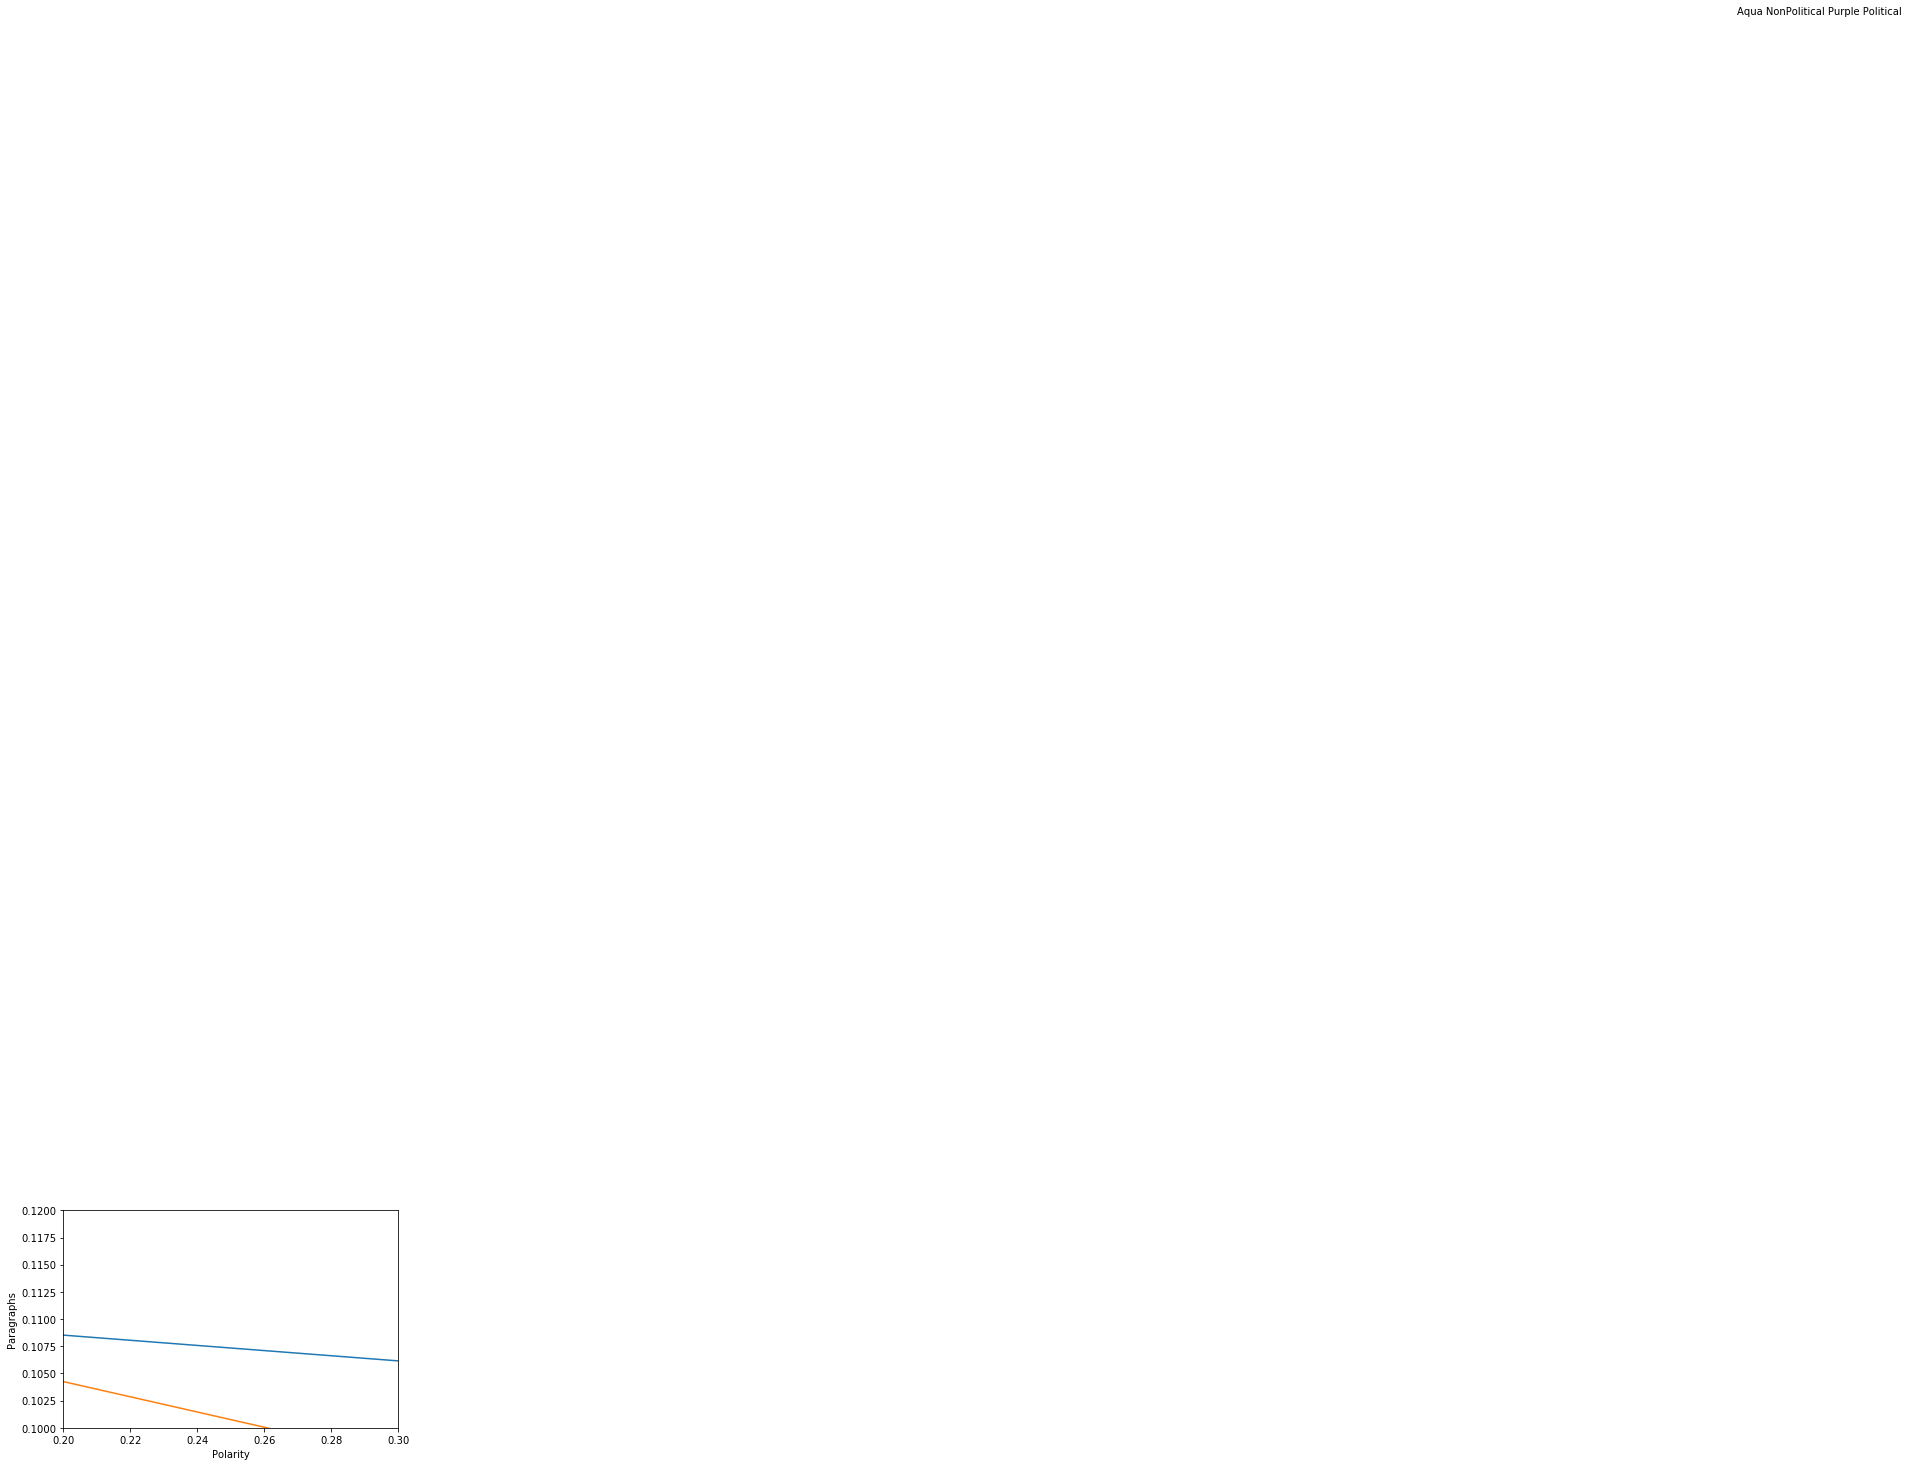

In [121]:
plt.xlabel("Polarity")
plt.ylabel("Paragraphs")
plt.axis([0.200,0.300,0.10,0.12])
plt.plot(nlrel)
plt.plot(lrk)
plt.text(0.7,0.23,r'Aqua NonPolitical Purple Political')
plt.show()